In [1]:
from typing import List, Tuple
import numpy as np
import os

def extract_segments_and_labels(ds_path: str) -> Tuple[List[np.ndarray], List[str]]:
    segments, labels = [], []
    for fp in os.listdir(ds_path):
        label = fp[:fp.index("_")]
        segment = np.load(os.path.join(ds_path, fp))
        labels.append(label)
        segments.append(segment)
    return segments, labels

segments, labels = extract_segments_and_labels("Chestnut")

In [2]:
from typing import Callable, Union

def _fn_per_band(ar: np.ndarray, fn: Callable[[np.ndarray], np.ndarray]):
    """Runs an operation for each band in an NDArray."""
    ar = ar.copy()
    ar_bands = []
    for band in range(ar.shape[-1]):
        ar_band = ar[:, :, band]
        ar_band = fn(ar_band)
        ar_bands.append(ar_band)
    return np.stack(ar_bands, axis=-1)


def scale_0_1_per_band(
    ar: np.ndarray, epsilon: Union[float, bool] = False
) -> np.ndarray:
    """Scales an NDArray from 0 to 1 for each band independently

    Args:
        ar: NDArray of shape (H, W, C), where C is the number of bands.
        epsilon: If True, then we add a small epsilon to the denominator to
            avoid division by zero. If False, then we do not add epsilon.
            If a float, then we add that float as epsilon.
    """
    epsilon = 1e-7 if epsilon is True else epsilon

    return _fn_per_band(
        ar,
        lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x) + epsilon),
    )

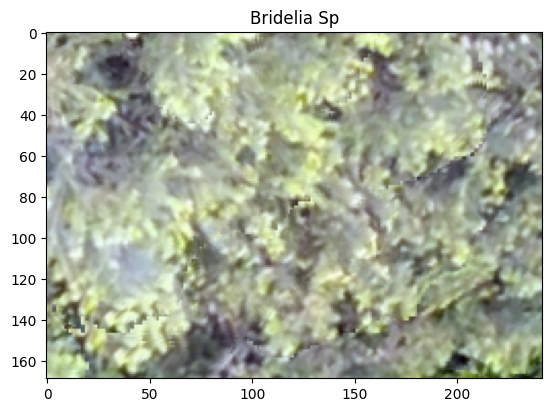

In [3]:
import matplotlib.pyplot as plt

def visualize(segment: np.ndarray, label: str):
    segment_0_rgb = segment[..., [2, 1, 0]]
    segment_0_rgb_scaled = scale_0_1_per_band(segment_0_rgb)

    plt.imshow(segment_0_rgb_scaled)
    plt.title(f"{label}")
    plt.show()

visualize(segments[1], labels[1])

In [4]:
from typing import Dict, Tuple

def get_filtered_labels(labels: List[str]):
    # count number of examples for each label, filter only labels >= 2
    counter = {}
    for label in labels:
        counter[label] = counter.get(label, 0) + 1
    filtered_labels = {label for label, count in counter.items() if count > 1}
    return filtered_labels

def get_crowns(segments: List[np.ndarray], labels: List[str], filtered_labels: set) -> Dict[str, np.ndarray]:
    crowns = {}
    for label, segment in zip(labels, segments):
        if label in filtered_labels:
            if label not in crowns:
                crowns[label] = []
            crowns[label].append(segment.transpose(2, 0, 1).reshape(8, -1))
    for label, _ in crowns.items():
        crowns[label] = np.hstack(crowns[label])
        # create NaN mask
        mask = ~np.isnan(crowns[label]).any(axis=0)
        crowns[label] = crowns[label][:, mask]
    return crowns

def get_random_pixels(crowns: Dict[str, List[np.ndarray]], 
                      pixel_count: int = 20000,
                      seed: int = 42) -> Dict[str, np.ndarray]:
    np.random.seed(seed)
    simulated_crowns = {}
    for label, segs in crowns.items():
        idxes = np.random.choice(segs.shape[-1], pixel_count)
        simulated_crowns[label] = segs[:, idxes]
    return simulated_crowns

def create_simulated_plots(simulated_crowns: Dict[str, np.ndarray],
                           species_per_eu: int = 1,
                           eu_size: Tuple[int, int] = (36, 36),
                           num_eu: int = 9,
                           seed: int = 21) -> Tuple[List[List[str]], np.ndarray]:
    np.random.seed(seed)
    width = int(num_eu ** 0.5)
    simulated_plot = np.empty((8, (eu_size[0] * width), (eu_size[1] * width)))
    labels = [[] for _ in range(3)]
    for i, (species, points) in enumerate(simulated_crowns.items()):
        idxes = np.random.choice(points.shape[-1], eu_size[0] * eu_size[1])
        selected_points = points[:, idxes].reshape((8, eu_size[0], eu_size[1]))
        x, y = i % 3, i // 3
        labels[y].append(species)
        simulated_plot[:, x*eu_size[0]:(x+1)*eu_size[0], y*eu_size[1]:(y+1)*eu_size[1]] = selected_points
    return labels, simulated_plot

filtered_labels = get_filtered_labels(labels)
crowns = get_crowns(segments, labels, filtered_labels)
simulated_crowns = get_random_pixels(crowns)
labels, simulated_plots = create_simulated_plots(simulated_crowns)

In [40]:
from sklearn.decomposition import PCA

# step 2: PCA on spectral pts
reshaped_crowns = np.transpose(np.hstack(simulated_crowns.values()), (1, 0))
pca = PCA(n_components=0.99)
pca_crowns = pca.fit_transform(reshaped_crowns)
print(pca.explained_variance_ratio_)

[0.94894285 0.04122758]


/tmp/ipykernel_2120/3183862029.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  reshaped_crowns = np.transpose(np.hstack(simulated_crowns.values()), (1, 0))


In [33]:
import matplotlib.pyplot as plt
from matplotlib import colors

def plot_spectral_species(reshaped_plot_preds: np.ndarray, num_clusters: int):
    clrs = ['k','b','y','g','r', 'c', 'm', 'w']
    cmap = colors.ListedColormap(clrs[:num_clusters])
    plt.imshow(reshaped_plot_preds, interpolation='nearest', cmap=cmap)
    plt.title(f"plot of diff species with {num_clusters} clusters")
    plt.tight_layout()
    plt.show()

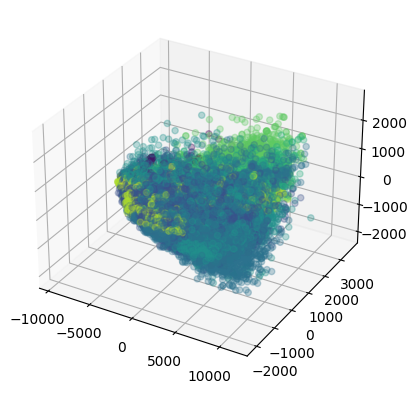

In [39]:
# PCA using 3 components 
# To get this to work, need to change n_components in the PCA variable above to 3
 
fig = plt.figure()
ax = plt.axes(projection='3d')
y = np.repeat(np.arange(9), 20000)
ax.scatter(pca_crowns[:,0], pca_crowns[:,1], pca_crowns[:,2], c=y, alpha=0.3)
plt.show()

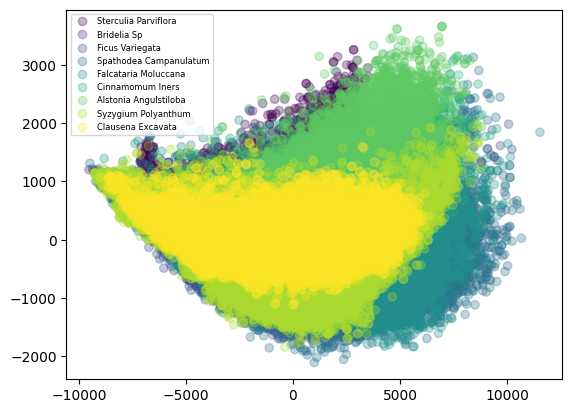

In [43]:
# PCA using 2 components

y = np.repeat(np.arange(9), 20000)
plot = plt.scatter(pca_crowns[:,0], pca_crowns[:,1], c=y, alpha=0.3)
plt.legend(handles=plot.legend_elements()[0], prop={'size': 6}, labels=simulated_crowns.keys())
plt.show()

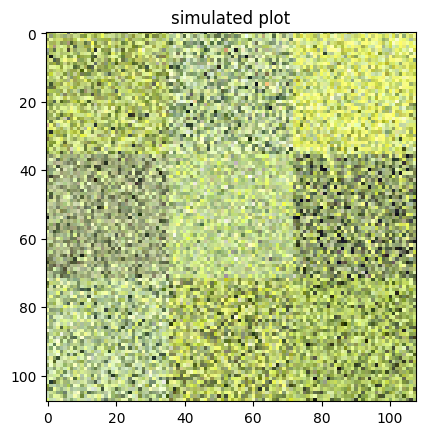

[['Sterculia Parviflora', 'Bridelia Sp', 'Ficus Variegata'],
 ['Spathodea Campanulatum', 'Falcataria Moluccana', 'Cinnamomum Iners'],
 ['Alstonia Angulstiloba', 'Syzygium Polyanthum', 'Clausena Excavata']]


In [24]:
# visualizing the simulated plot

from pprint import pprint 
visualize(np.transpose(simulated_plots, (1, 2, 0)), "simulated plot")
pprint(labels)

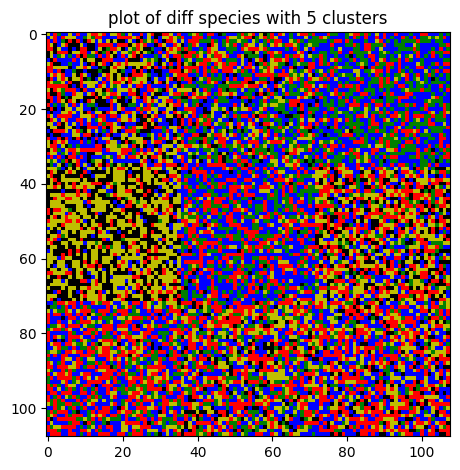

In [25]:
from sklearn.cluster import KMeans

# step 3: kmeans on a subset of points - using 5 clusters
num_clusters = 5
random_idxes = np.random.choice(pca_crowns.shape[0], 10000)
random_pts = pca_crowns[random_idxes, :]
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(random_pts)
# step 4: experimentation
reshaped_plot = pca.transform(np.reshape(np.transpose(simulated_plots, (1, 2, 0)), (-1, 8)))
reshaped_plot_preds = kmeans.predict(reshaped_plot.astype("float32"))
reshaped_plot_preds = np.reshape(reshaped_plot_preds, (108, 108))
# plot spectral species
plot_spectral_species(reshaped_plot_preds=reshaped_plot_preds, 
                      num_clusters=num_clusters)

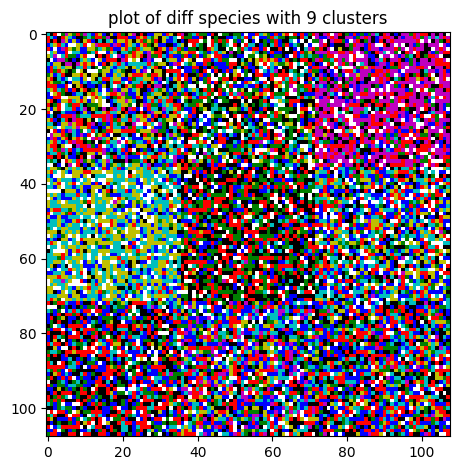

In [28]:
# step 3: kmeans on a subset of points - using 9 clusters
num_clusters = 9
random_idxes = np.random.choice(pca_crowns.shape[0], 10000)
random_pts = pca_crowns[random_idxes, :]
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(random_pts)
# step 4: experimentation
reshaped_plot = pca.transform(np.reshape(np.transpose(simulated_plots, (1, 2, 0)), (-1, 8)))
reshaped_plot_preds = kmeans.predict(reshaped_plot.astype("float32"))
reshaped_plot_preds = np.reshape(reshaped_plot_preds, (108, 108))
# plot spectral species
plot_spectral_species(reshaped_plot_preds=reshaped_plot_preds, num_clusters=num_clusters)

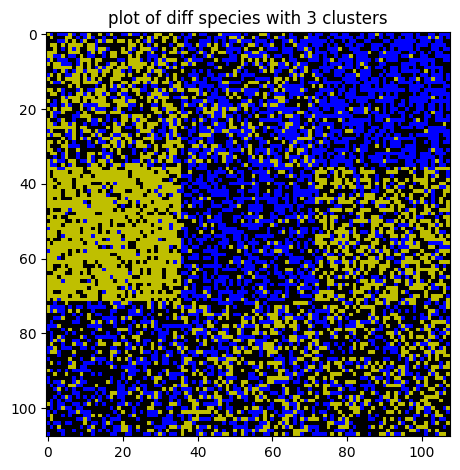

In [29]:
# step 3: kmeans on a subset of points - using 3 clusters
num_clusters = 3
random_idxes = np.random.choice(pca_crowns.shape[0], 10000)
random_pts = pca_crowns[random_idxes, :]
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(random_pts)
# step 4: experimentation
reshaped_plot = pca.transform(np.reshape(np.transpose(simulated_plots, (1, 2, 0)), (-1, 8)))
reshaped_plot_preds = kmeans.predict(reshaped_plot.astype("float32"))
reshaped_plot_preds = np.reshape(reshaped_plot_preds, (108, 108))
# plot spectral species
plot_spectral_species(reshaped_plot_preds=reshaped_plot_preds, num_clusters=num_clusters)

In [ ]:
# TO-DO
# May be able to leverage existing libraries to do that

def shannon_index(arr: np.ndarray) -> np.ndarray:
    if arr.sum() != 1.0:
        arr = arr / arr.sum()
    score = -np.sum(arr * np.log(arr))
    return score

def bc_dissimilarity(abundances_matrices: np.ndarray) -> np.ndarray:
    """
    abundances_matrices will be a matrix of 2 dimensions
    m x n, where m is the number of species and n is the number of plots
    n(ik) represents the relative abundance of species k in plot i
    """
    pass
    